## Step 1: Convert MRI Slices to NIfTI

In this step, a set of **2D MRI slices** are loaded, resized, and stacked into a **3D volume** using NumPy. The final volume is then saved as a **NIfTI file (.nii.gz)** using the NiBabel library.


In [1]:
import os
import numpy as np
from PIL import Image
import nibabel as nib

# === CONFIGURATION for train Data ===
input_folder = './BrainHack/final_project/Data_train/MRI'
output_file = './BrainHack/final_project/BraTS2021_00002_train.nii.gz'

'''
# === CONFIGURATION for test Data ===
input_folder = './BrainHack/final_project/Data_test/MRI'
output_file = './BrainHack/final_project/BraTS2021_00002_test.nii.gz'
'''

# === LOAD IMAGES AND STACK INTO 3D ARRAY ===
image_files = [f for f in os.listdir(input_folder) if f.endswith('.png')]
image_files = sorted(image_files, key=lambda x: int(x.split('.')[0]))

# Determine target size (use the first image as reference)
first_image = Image.open(os.path.join(input_folder, image_files[0])).convert('L')
target_size = first_image.size  # (width, height)

slices = []
for f in image_files:
    img_path = os.path.join(input_folder, f)
    img = Image.open(img_path).convert('L').resize(target_size)
    slices.append(np.array(img))

# Stack images to form 3D volume
volume = np.stack(slices, axis=-1)

# === SAVE AS NIfTI FILE ===
nii_img = nib.Nifti1Image(volume, affine=np.eye(4))
nib.save(nii_img, output_file)

print("✅ NIfTI file created successfully:", output_file)


✅ NIfTI file created successfully: /mnt/c/Users/Yadollah/Desktop/my_work/BrainHack/final_project/BraTS2021_00002_test.nii.gz


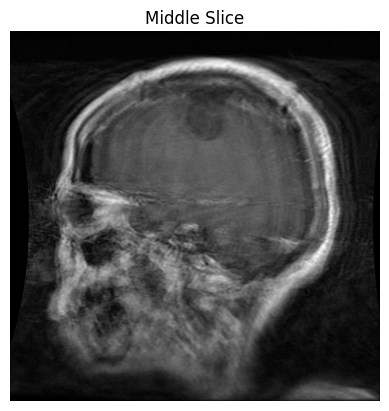

In [2]:
import nibabel as nib
import matplotlib.pyplot as plt

# Path to your NIfTI file
nii_path = './BrainHack/final_project/BraTS2021_00002_train.nii.gz'

# Load the NIfTI file
img = nib.load(nii_path)
data = img.get_fdata()

# Show one slice (e.g., middle slice)

plt.imshow(data[:, :, 55], cmap='gray')
plt.title('Middle Slice')
plt.axis('off')
plt.show()

## Step 2: Extract Tumor Bounding Boxes

Mask images are processed using **OpenCV** to detect tumor regions. For each detected region, the **center coordinates** and **maximum diameter** are computed. This information is then saved into an **Excel file** for later use in model training or evaluation.

In [3]:
import os
import cv2
import pandas as pd
import os
import numpy as np
from PIL import Image
import nibabel as nib


# === CONFIGURATION for Train Data ===
mask_folder = './Brainhack/final_project/Data_Train/Mask'  # your mask image folder
output_excel = './Brainhack/final_project/bounding_boxes_train.xlsx'

'''
# === CONFIGURATION for Test Data ===
mask_folder = './Brainhack/final_project/Data_Test/Mask'  # your mask image folder
output_excel = './Brainhack/final_project/bounding_boxes_test.xlsx'
'''
# === COLLECT BOUNDING BOXES ===
bbox_data = []

for filename in os.listdir(mask_folder):
    if filename.endswith(('.png')):
        path = os.path.join(mask_folder, filename)
        mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        # Find contours in binary mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            Center_x = int(x + w/2)
            Center_y = int(y + h/2)
            dia = np.max([w,h])
            bbox_data.append({
                'filename': filename,
                'x-pos': Center_x,
                'y-pos': Center_y,
                'dia': dia,
            })

# === SAVE TO EXCEL ===
df = pd.DataFrame(bbox_data)
df.to_excel(output_excel, index=False)
print(f"Saved bounding boxes to: {output_excel}")

Saved bounding boxes to: /mnt/c/Users/Yadollah/Desktop/my_work/Brainhack/final_project/bounding_boxes_test.xlsx


In [9]:
df

,filename,x-pos,y-pos,dia
0,1.png,323,214,113
1,10.png,268,288,74
2,100.png,198,221,90
3,1000.png,250,222,50
4,1001.png,252,223,55
...,...,...,...,...
3063,995.png,251,206,73
3064,996.png,257,203,56
3065,997.png,263,204,48
3066,998.png,256,228,45


## Step 3: Tumor Size Analysis

This step analyzes tumor diameter distribution to guide anchor shape selection for the Region Proposal Network (RPN). Tumors are categorized into **Small**, **Medium**, and **Large** based on size. Bar and pie charts visualize the count and proportion of tumors in each group, helping to design anchors that better match tumor scales.

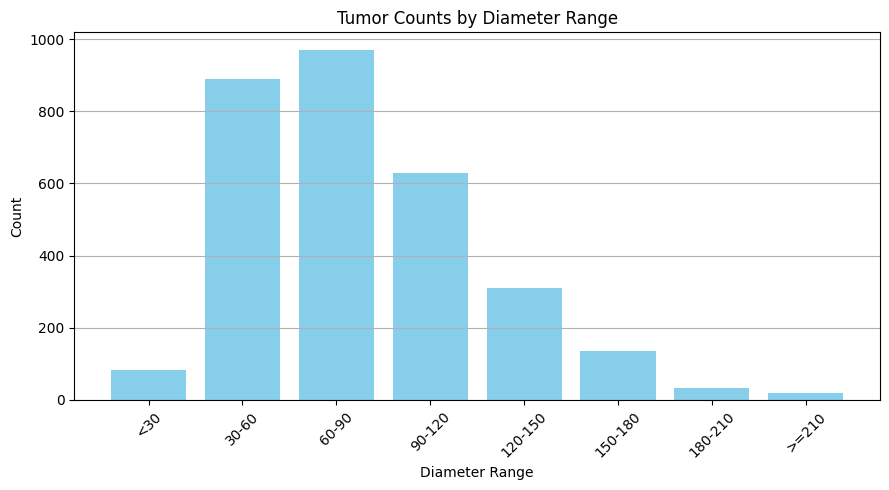

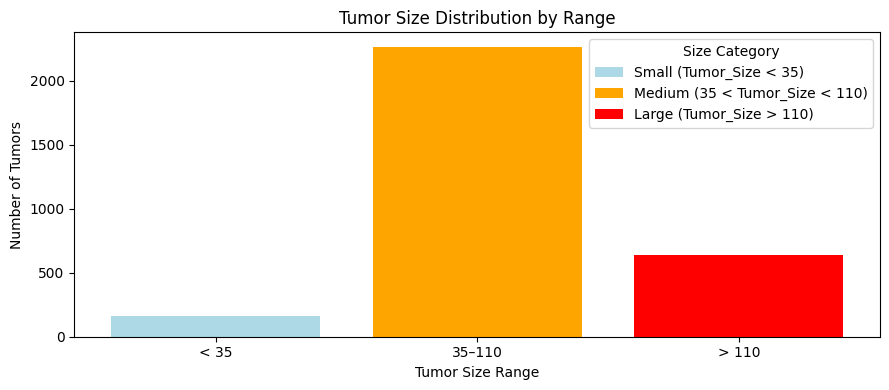

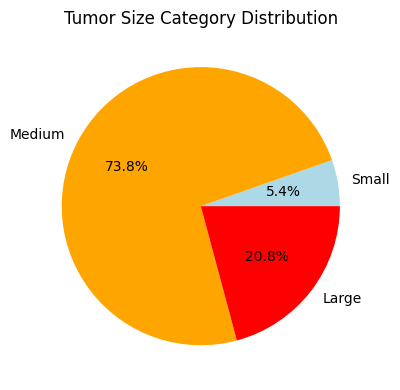

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# === Load Excel File ===
excel_path = './Brainhack/final_project/bounding_boxes_train.xlsx'  # Replace with your actual file path
df = pd.read_excel(excel_path)

# === Define Categories ===
def categorize_size(size):
    if size < 35:
        return 'Small'
    elif 35 <= size <= 110:
        return 'Medium'
    else:
        return 'Large'

df['size_category'] = df['dia'].apply(categorize_size)

# Define diameter ranges and calculate counts for each range
diameter = df['dia']
diameter_ranges = [(0, 30), (30, 60), (60, 90), (90, 120), 
                    (120, 150), (150, 180), (180, 210), (210, np.inf)]
range_labels = ['<30', '30-60', '60-90', '90-120', 
                '120-150', '150-180', '180-210', '>=210']
counts = [np.sum((diameter >= lower) & (diameter < upper)) 
          for lower, upper in diameter_ranges]

# Create a bar chart for nodule counts by diameter range
plt.figure(figsize=(9, 5))
plt.bar(range_labels, counts, color='skyblue')
plt.xlabel('Diameter Range')
plt.ylabel('Count')
plt.title('Tumor Counts by Diameter Range')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


# === Count per Category ===
category_counts = df['size_category'].value_counts().reindex(['Small', 'Medium', 'Large'], fill_value=0)

# === Bar Chart Settings ===
x_labels = ['< 35', '35–110', '> 110']
colors = ['lightblue', 'orange', 'red']
categories = ['Small (Tumor_Size < 35)', 'Medium (35 < Tumor_Size < 110)', 'Large (Tumor_Size > 110)']

# === Bar Chart ===
plt.figure(figsize=(9, 4))
bars = plt.bar(x_labels, category_counts.values, color=colors)

# Add legend
for bar, label in zip(bars, categories):
    bar.set_label(label)

plt.xlabel('Tumor Size Range')
plt.ylabel('Number of Tumors')
plt.title('Tumor Size Distribution by Range')
plt.legend(title='Size Category')
plt.tight_layout()
plt.show()


# === Pie Chart ===
plt.figure(figsize=(5, 4))
plt.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%', colors=colors)
#plt.legend(['Small (Tumor_Size < 35)', 'Medium (35 < Tumor_Size < 110)', 'Large (Tumor_Size > 110)'])
plt.title('Tumor Size Category Distribution')
plt.tight_layout()
plt.show()

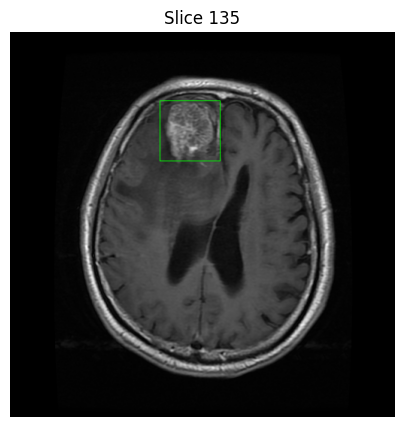

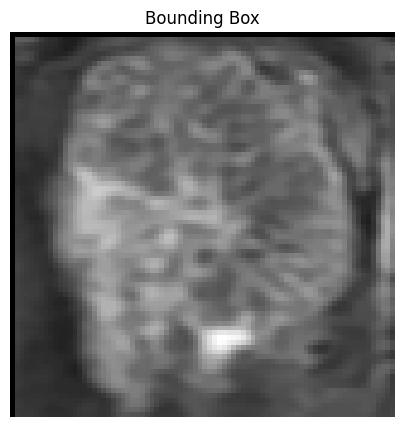

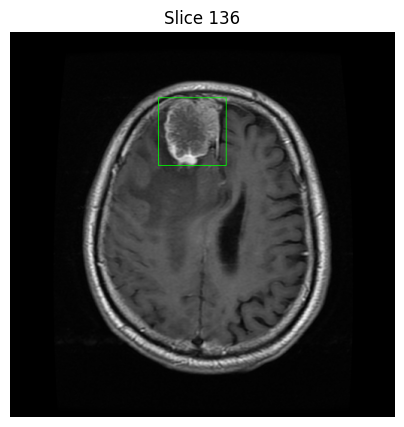

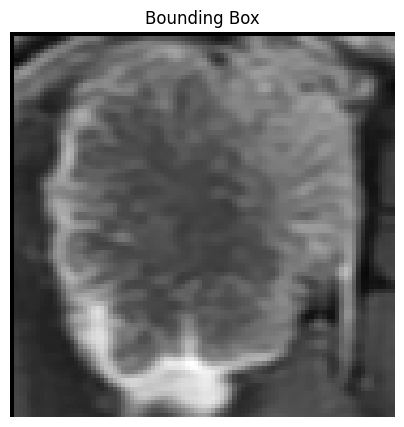

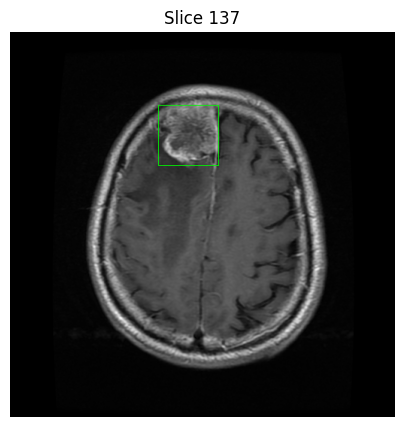

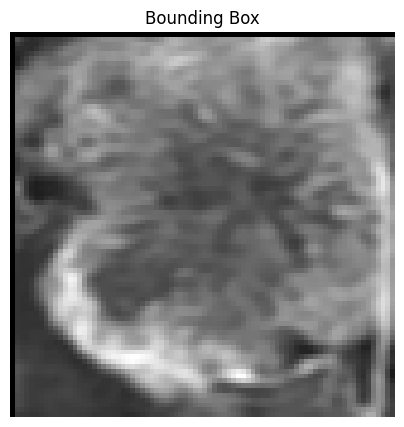

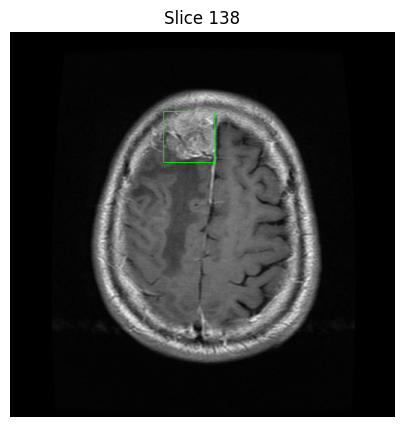

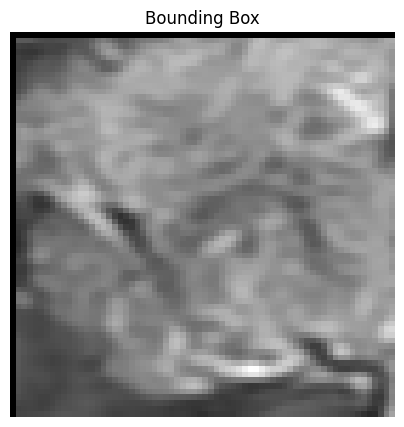

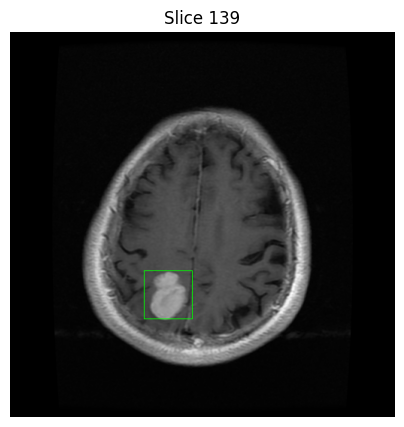

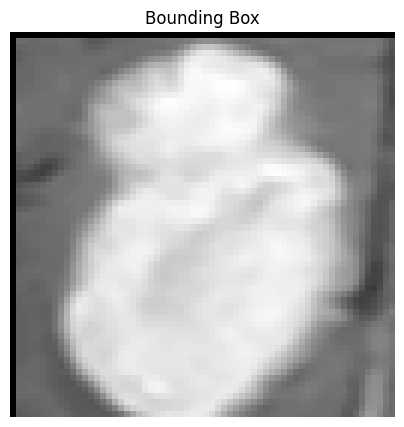

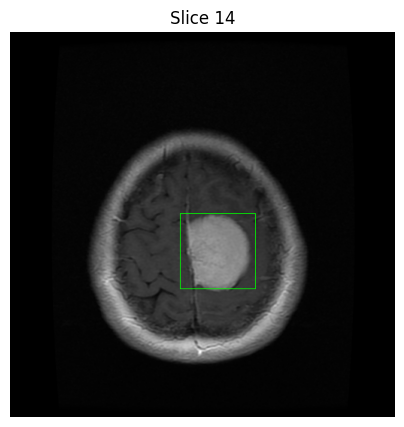

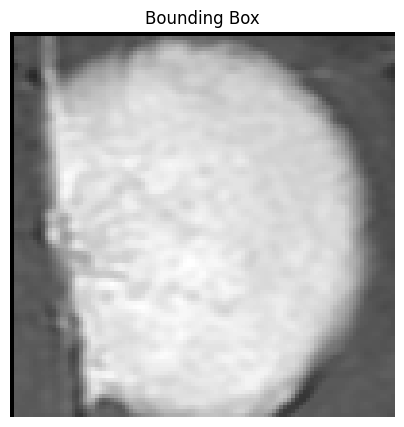

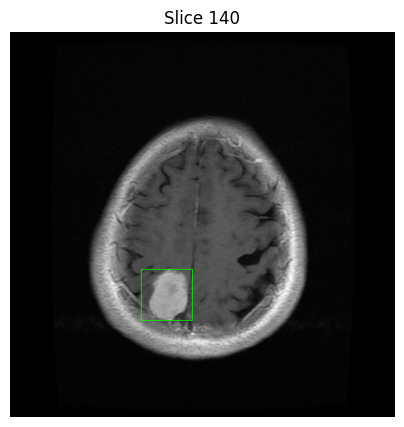

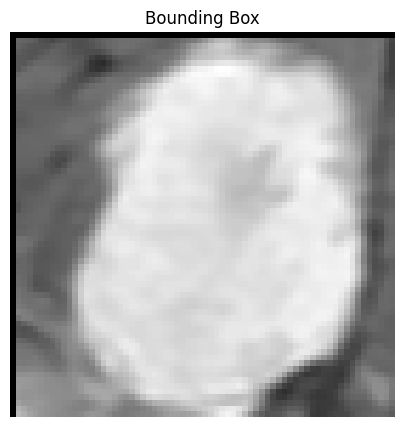

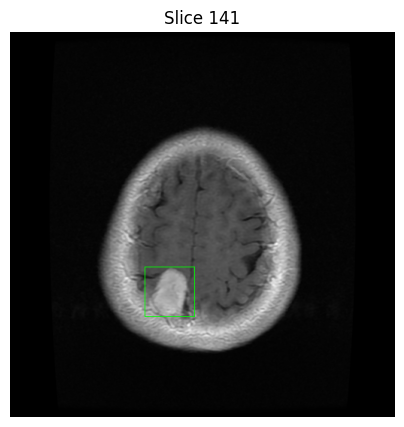

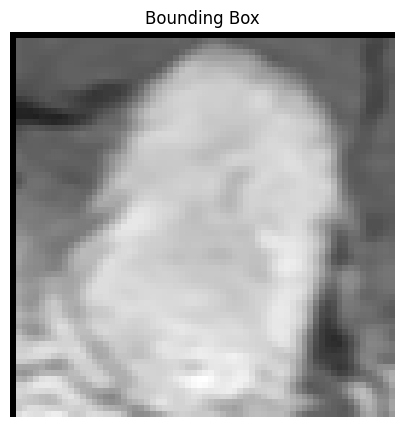

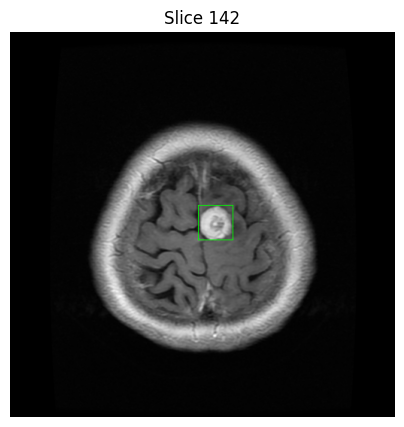

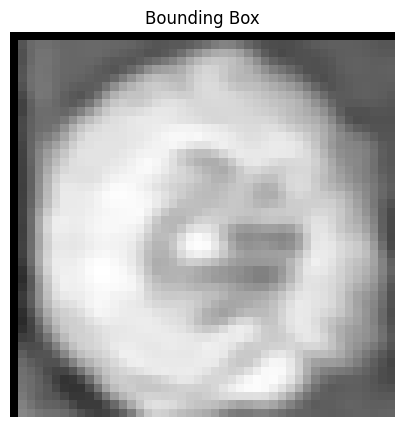

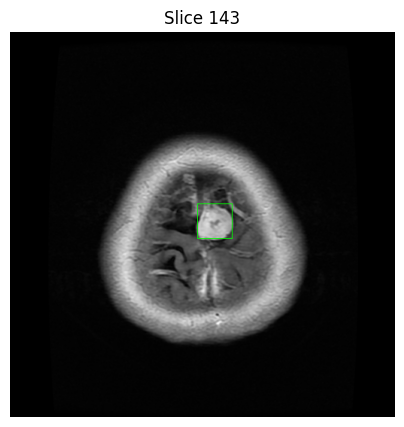

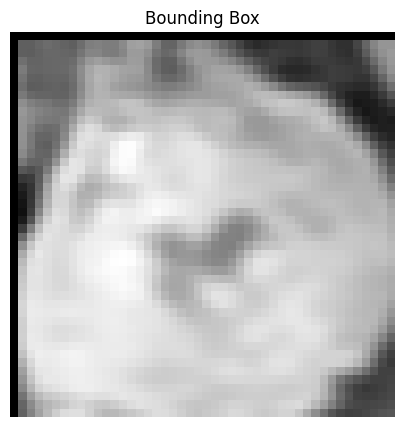

In [6]:
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
from PIL import Image

# === Load NIfTI MRI image ===
nifti_path = './BrainHack/final_project/BraTS2021_00002_train.nii.gz'
img = nib.load(nifti_path)
img_data = img.get_fdata()

# === Load bounding box info from Excel ===
df = pd.read_excel('./Brainhack/final_project/bounding_boxes_train.xlsx')  # columns: slice, x, y, width, height


# === Iterate over each row and draw the bounding box on the correct slice ===
row1 = list(df.iterrows())
for i in range(40,50):
    row = row1[i][1]

    # Extract slice index from filename (e.g., '5.png' -> 5)
    slice_index = int(row['filename'].replace('.png', ''))
    #x_min, y_min, x_max, y_max = int(row['x_min']), int(row['y_min']), int(row['x_max']), int(row['y_max'])

    # Get the 2D slice from the 3D image
    slice_img = img_data[:, :, slice_index-1]

    # Normalize and convert to uint8
    slice_img = np.uint8(255 * (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img)))
    color_img = cv2.cvtColor(slice_img, cv2.COLOR_GRAY2BGR)

     # Extract the Bounding Box
    Center_x = row['x-pos']
    Center_y = row['y-pos']
    dia = row['dia']

    x_min1 = Center_x - int(dia/2)
    x_max1 = Center_x + int(dia/2)
    y_min1 = Center_y - int(dia/2)
    y_max1 = Center_y + int(dia/2)
    
    Bounding_Box = color_img[y_min1:y_max1,x_min1:x_max1,0]

    # Draw the bounding box
    cv2.rectangle(color_img, (x_min1, y_min1), (x_max1, y_max1), (0, 255, 0), 1)

    
    Bounding_Box = color_img[y_min1:y_max1,x_min1:x_max1,0]
    
    # Show the image
    plt.figure(figsize=(5, 5))
    plt.imshow(color_img)
    plt.title(f'Slice {slice_index}')
    plt.axis('off')
    plt.show()

    # Show the Bounding Box
    plt.figure(figsize=(5, 5))
    plt.imshow(Bounding_Box, cmap = 'gray')
    plt.title('Bounding Box')
    plt.axis('off')
    plt.show()